### Imports

In [10]:
import copy
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import matplotlib.pyplot as plt

from ipywidgets import widgets, interact
from livelossplot import PlotLosses
from IPython.display import display
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.model_selection import KFold

# Torch
import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch import Tensor
from torch.nn import BatchNorm2d, Dropout2d, Sequential, Linear, Conv2d, MaxPool2d, ReLU, Softmax, Module, CrossEntropyLoss
from torchinfo import summary
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_, xavier_uniform_
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize

# Seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0) 

### Constantes

In [3]:
# Paths dos ficheiros brutos para serem processados
PATH_TRAIN_CSV = './data/train.csv'
PATH_TRAIN_IMG = './data/train_data.mat'
PATH_TEST_CSV = './data/test.csv'
PATH_TEST_IMG = './data/test_data.mat'

# Path dos ficheiros processados para serem usados no modelo
PATH_TRAIN = './processed-data/train_relations_not_null_data.csv'
PATH_TEST = './processed-data/test_relations_not_null_data.csv'

# Constantes para o processo de treino
EPOCHS = 120
BATCH_SIZE = 30
LEARNING_RATE = 0.001
device = torch.device("cuda")

# Constantes de cross-validation
K_FOLDS = 5
K_EPOCHS = 25

# 1 - Exploração e Preparação dos Dados

### Classes de datasets e data loaders

In [18]:
# Classe para o dataset de treino
class CSVDataset(Dataset):
    def __init__(self, dataframe):
        # y - outputs (idade), x - inputs (o resto)
        self.y = torch.tensor(dataframe['age'].values, dtype=torch.float32)
        self.y = self.y.reshape((len(self.y), 1))
        self.x = torch.tensor(dataframe.drop(columns='age').values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        data = self.x[idx]
        return [data, label]

    # retornar índices para casos de treino de de teste
    def get_splits(self, train_size, val_size):
        return random_split(self, [train_size, val_size])#, generator=torch.Generator().manual_seed(42))

# Loader do dataset de treino
def prepare_train_data_loaders(path_train):
    # Ler dataset
    df = pd.read_csv(path_train, header=0)

    # Dividir dataset em treino e validação (cerca de 80%-20%)
    dataset = CSVDataset(df)
    train_size = 90 # múltiplo de 30 (BATCH_SIZE)
    val_size = 22 # 112 - train_size
    train, validation = dataset.get_splits(train_size, val_size)

    # Dataloaders de treino e validação
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)

    # Para além de retornar os dataloaders, retorna o número de inputs que o modelo MLP deverá ter (df.shape[1]-1)
    return train_dl, val_dl, train_dl_all, val_dl_all, df.shape[1]-1

# Classe para o dataset de teste (não tem os valores da idade - y)
class CSVTestDataset(Dataset):
    def __init__(self, dataframe):
        self.x = torch.tensor(dataframe.values, dtype=torch.float32)
            
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        data = self.x[idx]
        return data

# Loader do dataset de teste
def prepare_test_data_loaders(path_train):
    # Ler dataset
    test_df = pd.read_csv(path_train, header=0)

    test = CSVTestDataset(test_df)

    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)

    return test_dl, test_dl_all

### 1.1 - Visualização dos dados

In [11]:
# Ler ficheiros MAT
def get_data_from_mat(train_file,test_file):
    train_mat = scipy.io.loadmat(train_file) 
    test_mat = scipy.io.loadmat(test_file) 
    train_np = np.array(train_mat['train_data']).transpose(2,0,1)
    test_np = np.array(test_mat['test_data']).transpose(2,0,1)
    return  train_np, test_np

# Ler ficheiros
def load_data(path_train_csv, path_train_img, path_test_csv, path_test_img):
    # Ler ficheiros CSV
    train_csv = pd.read_csv(path_train_csv, header=0)
    test_csv = pd.read_csv(path_test_csv, header=0)

    # Ler ficheiros MAT
    train_img, test_img = get_data_from_mat(path_train_img, path_test_img)
    return train_csv, test_csv, train_img, test_img

# Visualizar ficheiros MAT
def visualize(image):
    plt.imshow(image, cmap="gray")    
    plt.show()      

def show_ds(ds):
    print("ds shape:",ds.shape)
    print("ds max:",np.max(ds))
    print("ds min:",np.min(ds))
    print("ds average:",np.average(ds))
    @interact
    def visualize_set(scan_index=(0,len(ds)-1)):
        visualize(ds[scan_index,:,:])

train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)

print("Data de treino:")
print(train_csv)
show_ds(train_img)
print("Data de Teste:")
print(test_csv)
show_ds(test_img)

Data de treino:
      id  age  sex  education
0      1   13    1          7
1      2   14    0          8
2      3   15    1          9
3      4   15    1          9
4      5   15    1          9
..   ...  ...  ...        ...
107  108   77    1          4
108  109   67    0          4
109  110   55    0          4
110  111   76    1          3
111  112   69    0          4

[112 rows x 4 columns]
ds shape: (112, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024116160549305543


interactive(children=(IntSlider(value=55, description='scan_index', max=111), Output()), _dom_classes=('widget…

Data de Teste:
    id  sex  education
0    1    0         13
1    2    0         11
2    3    1          9
3    4    1         13
4    5    0         12
5    6    0         17
6    7    0          9
7    8    0          4
8    9    1          9
9   10    1          4
10  11    1         14
11  12    0          9
12  13    1          2
13  14    1          5
14  15    1          9
15  16    1         11
16  17    1          9
17  18    0         17
18  19    1         15
19  20    1         14
20  21    1          4
21  22    0          4
22  23    1          4
23  24    0          0
24  25    1          2
25  26    1          4
26  27    1          3
27  28    1          4
ds shape: (28, 90, 90)
ds max: 1.0
ds min: 0.0
ds average: 0.024994026906171023


interactive(children=(IntSlider(value=13, description='scan_index', max=27), Output()), _dom_classes=('widget-…

### 1.2 - Preparação dos dados

In [16]:
# Funções de processamento dos dados
def fix_sex_id_columns(train_csv, test_csv):
    for csv in [train_csv, test_csv]:
        female = csv['sex']
        male = []
        for person in female:
            if person==1:
                male.append(0)
            else:
                male.append(1)
        csv.drop('sex', axis='columns', inplace=True)
        csv['female']=female
        csv['male']=male
        csv.drop('id', axis='columns', inplace=True)
    return train_csv, test_csv
    
def img_to_list(img):
    tamanho = len(img)
    lista = []
    # triangular inferior sem diagonal
    for linha in range(tamanho):
        for coluna in range(linha):
            lista.append(img[linha][coluna])
    return lista

def imgs_to_matrix(imgs):
    matrix = []
    for img in imgs:
        matrix.append(img_to_list(img))
    return matrix

def join_data(train_csv, test_csv, train_img, test_img):
    train_matrix = imgs_to_matrix(train_img)
    test_matrix = imgs_to_matrix(test_img)
    train_data  = pd.concat([train_csv, pd.DataFrame(train_matrix)], axis=1)
    train_data.columns = list(train_csv.columns) + [f'rel-{i}' for i in range(len(train_matrix[0]))]
    test_data = pd.concat([test_csv, pd.DataFrame(test_matrix)], axis=1)
    test_data.columns = list(test_csv.columns) + [f'rel-{i}' for i in range(len(test_matrix[0]))]
    return train_data , test_data

def remove_non_relations(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
        data.drop('female', axis='columns', inplace=True)
        data.drop('male', axis='columns', inplace=True)
    return train_data, test_data

def remove_education(train_data, test_data):
    for data in [train_data, test_data]:
        data.drop('education', axis='columns', inplace=True)
    return train_data, test_data

def remove_null_columns(train_data, test_data):
    columns_to_drop = []
    for column_name in test_data.columns:
        if (train_data[column_name] == 0).all() and (test_data[column_name] == 0).all():
            columns_to_drop.append(column_name)

    train_data = train_data.drop(columns_to_drop, axis=1)
    test_data = test_data.drop(columns_to_drop, axis=1)

    return train_data, test_data, columns_to_drop

# Processamento dos dados e armazenamento dos dados processados
train_csv, test_csv, train_img, test_img = load_data(PATH_TRAIN_CSV, PATH_TRAIN_IMG, PATH_TEST_CSV, PATH_TEST_IMG)
train_csv_fix, test_csv_fix = fix_sex_id_columns(train_csv, test_csv)

# everything (sex, education, relations)
train_complete_data, test_complete_data = join_data(train_csv_fix, test_csv_fix, train_img, test_img)

train_complete_data.to_csv('./processed-data/train_complete_data.csv', index=False)
test_complete_data.to_csv('./processed-data/test_complete_data.csv', index=False)

# without null relations (sex, education, not-null relations)
train_complete_not_null_data, test_complete_not_null_data, unrelated_brain_zones = remove_null_columns(copy.copy(train_complete_data), copy.copy(test_complete_data))

train_complete_not_null_data.to_csv('./processed-data/train_complete_not_null_data.csv', index=False)
test_complete_not_null_data.to_csv('./processed-data/test_complete_not_null_data.csv', index=False)

# only sex and not-null relations
train_sex_not_null_data, test_sex_not_null_data = remove_education(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

train_sex_not_null_data.to_csv('./processed-data/train_sex_not_null_data.csv', index=False)
test_sex_not_null_data.to_csv('./processed-data/test_sex_not_null_data.csv', index=False)

# only not-null relations
train_relations_not_null_data, test_relations_not_null_data = remove_non_relations(copy.copy(train_complete_not_null_data), copy.copy(test_complete_not_null_data))

train_relations_not_null_data.to_csv('./processed-data/train_relations_not_null_data.csv', index=False)
test_relations_not_null_data.to_csv('./processed-data/test_relations_not_null_data.csv', index=False)

# only relations (null and not-null relations)
train_relations_data, test_relations_data = remove_non_relations(copy.copy(train_complete_data), copy.copy(test_complete_data))

train_relations_data.to_csv('./processed-data/train_relations_data.csv', index=False)
test_relations_data.to_csv('./processed-data/test_relations_data.csv', index=False)

### 1.3 - Seleção dos dados de treino

90 casos de treino média 43.92222213745117 || 22 casos de validação média 45.90909194946289


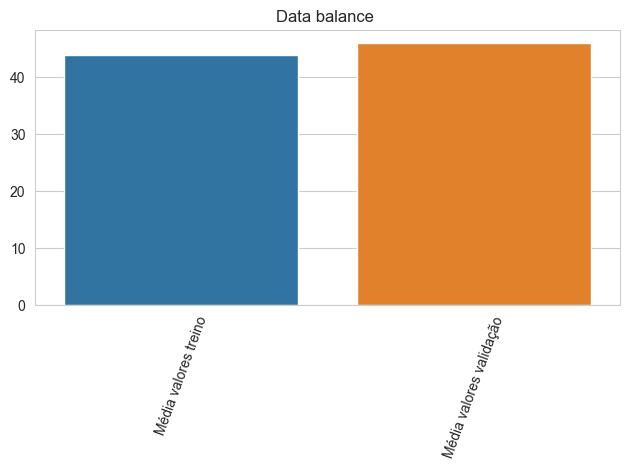

,0,1,2,3,4,5,6,7,8,9,...,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202
0,age,rel-1,rel-3,rel-4,rel-5,rel-8,rel-13,rel-14,rel-15,rel-17,...,rel-3975,rel-3977,rel-3979,rel-3981,rel-3989,rel-3993,rel-3997,rel-3999,rel-4001,rel-4003
1,13,0.13152513068295066,0.0,0.13695039151507568,0.0,0.1463094835282487,0.08504357235067955,0.0,0.27153768530795785,0.6941960106503965,...,0.0,0.0,0.0,0.014926682256188676,0.0,0.0,0.0,0.0,0.5850060523860224,0.2806062271251331
2,14,0.11770352725560888,0.0,0.13299809511232405,0.037714477776214936,0.11342491582310929,0.10540277848429594,0.0,0.316890214857591,0.7569372231801426,...,0.0,0.0,0.0,0.031810609502218194,0.0,0.0,0.0,0.0,0.5994370017818766,0.20747818936911436
3,15,0.15580596397166746,0.0,0.1654291346173953,0.02227817462109693,0.09607963318316486,0.08788987272325399,0.0,0.3480716475756247,0.7844514493117679,...,0.0,0.0,0.0,0.021235216425020506,0.01804999835021417,0.0,0.0,0.0,0.6303735077739404,0.24647167768599754
4,15,0.14521446386863182,0.0,0.1624925814199255,0.0,0.12411458477169271,0.09794939291935065,0.0,0.3102695776218635,0.8006706490445937,...,0.0,0.0,0.0,0.01512992626682297,0.0,0.0,0.0,0.0,0.5625047108732929,0.2878876128467465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,77,0.21576667491869883,0.0,0.18494193783241825,0.01944638473680701,0.1099718901063309,0.1080905684647715,0.0,0.39033165627576394,0.7345744111069945,...,0.03316718489713255,0.015108487167287368,0.01643362637840082,0.056483035772704214,0.0,0.0,0.0,0.011150472478070992,0.6602918558628459,0.3026753383068725
109,67,0.1430050115257508,0.0,0.12435010951472804,0.0,0.09018890248147972,0.08936694625523896,0.0,0.30638034663390734,0.7568276622137461,...,0.0,0.013165506769402877,0.029519462267824488,0.05196410878016795,0.0,0.013097722203527673,0.011170836931819469,0.019141254000135794,0.6304154549754257,0.2041253280576364
110,55,0.1160847843891602,0.0,0.15640598132494415,0.020947137569371364,0.12258930443742344,0.09132464671190622,0.0,0.29094128118908275,0.8008432098836037,...,0.0,0.0,0.0,0.034193295163286515,0.010497958537702952,0.0,0.0,0.0,0.5743547251988937,0.24678357194266243
111,76,0.15665442423941386,0.0,0.16661323459706648,0.04646440036672482,0.0912442211721474,0.14748423338389025,0.017150519037560014,0.3575395968104339,0.6551286183171472,...,0.0,0.0,0.0,0.05149721459467968,0.012696512221254272,0.019894077761544175,0.010225005174065927,0.0,0.6310571080259276,0.21625939656444373


Quantidade de casos de Treino:90
Quantidade de casos de Teste:22
Shape tensor batch casos treino, input: torch.Size([30, 1202]), output: torch.Size([30, 1])
Shape tensor batch casos validação, input: torch.Size([22, 1202]), output: torch.Size([22, 1])


In [24]:
def visualize_holdout_balance(train_dl_all, val_dl_all):
    _, y_train = next(iter(train_dl_all))
    _, y_test = next(iter(val_dl_all))
    sns.set_style('whitegrid')
    casos_treino=len(y_train)
    casos_val=len(y_test)
    print(f'{casos_treino} casos de treino média {np.mean(y_train.numpy())} || {casos_val} casos de validação média {np.mean(y_test.numpy())}')
    grafico=sns.barplot(x=['Média valores treino','Média valores validação'],
    y=[np.mean(y_train.numpy()), np.mean(y_test.numpy())])
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    #plt.savefig('data_balance_MLP.png')
    plt.show()

def visualize_data(path):
    # criar uma instância do dataset
    df = pd.read_csv(path, header=None)
    display(df)
    
def visualize_dataset(train_dl, val_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Teste:{len(val_dl.dataset)}")
    x, y = next(iter(train_dl)) # fazer uma iteração nos loaders para ir buscar um batch de casos
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")

train_dl, val_dl, train_dl_all, val_dl_all, dim_num = prepare_train_data_loaders(PATH_TRAIN)

visualize_holdout_balance(train_dl_all, val_dl_all)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, val_dl)

# 2 Definir o Modelo

In [25]:
class MLP(Module):
    def __init__(self, num_inputs, num_hidden=[40,25,15]):
        super(MLP, self).__init__()
        # input -> hidden 1
        self.hidden1 = Linear(num_inputs, num_hidden[0] )
        xavier_uniform_(self.hidden1.weight)
        self.act1 = ReLU()
        
        # hidden 1 --> hidden 2
        self.hidden2 = Linear(num_hidden[0],num_hidden[1])
        xavier_uniform_(self.hidden2.weight)
        self.act2 = ReLU()
            
        # hidden 2 --> hidden 3
        self.hidden3 = Linear(num_hidden[1],num_hidden[2])
        xavier_uniform_(self.hidden3.weight)
        self.act3 = ReLU()
        
        # hidden 3 --> hidden 4
        self.hidden4 = Linear(num_hidden[2],1)
        xavier_uniform_(self.hidden4.weight)
        self.act4 = ReLU()

        # hidden 4 --> output
        # self.hidden5 = Linear(num_hidden[3],1)
        # xavier_uniform_(self.hidden5.weight)
        # self.act5 = ReLU()

    def forward(self, X):
        # start --> hidden1
        X = self.hidden1(X)
        X = self.act1(X)
        
        # hidden 1 --> hidden 2
        X = self.hidden2(X)
        X = self.act2(X)
        
        # hidden 2 --> hidden 3
        X = self.hidden3(X)
        X = self.act3(X)
        
        # hidden 3 --> hidden 4
        X = self.hidden4(X)
        # X = self.act4(X)
        
        # hidden 4 --> output
        # X = self.hidden5(X)
        # X = self.act5(X)
        return X

model = MLP(dim_num)
print(summary(model, input_size=(BATCH_SIZE, dim_num), verbose=2)) #verbose=2 Show weight and bias layers in full detail

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [30, 1]                   --
├─Linear: 1-1                            [30, 40]                  48,120
│    └─weight                                                      ├─48,080
│    └─bias                                                        └─40
├─ReLU: 1-2                              [30, 40]                  --
├─Linear: 1-3                            [30, 25]                  1,025
│    └─weight                                                      ├─1,000
│    └─bias                                                        └─25
├─ReLU: 1-4                              [30, 25]                  --
├─Linear: 1-5                            [30, 15]                  390
│    └─weight                                                      ├─375
│    └─bias                                                        └─15
├─ReLU: 1-6                              [30, 15]        

# 3 Treinar o Modelo

### Função de treino

In [27]:
def train_model(train_dl, val_dl, model, criterion, optimizer, epochs, file_path):
    for epoch in range(epochs):
        logs = {} # para o livelossplot
        
        # Train phase
        model.train() 
        epoch_loss = 0
        epoch_rmse = 0
        for batch_i, (inputs, labels) in enumerate(train_dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            rmse = np.sqrt(mean_squared_error(labels.reshape((len(labels), 1)).cpu().numpy(), outputs.detach().cpu().numpy()))
            loss.backward()
            optimizer.step()


            # Accumulate the loss and RMSE
            epoch_loss += loss.item()
            epoch_rmse += rmse.item()
        
        logs['loss'] = epoch_loss / len(train_dl)
        logs['rmse'] = epoch_rmse / len(train_dl)


        # Validation phase
        model.eval()
        val_loss = 0
        val_rmse = 0
        for batch_i, (val_inputs, val_labels) in enumerate(val_dl):
            # Perform forward pass
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model(val_inputs)
            
            # Calculate the loss and RMSE
            val_loss_batch = criterion(val_outputs, val_labels)
            val_rmse_batch = np.sqrt(mean_squared_error(val_labels.reshape((len(val_labels), 1)).cpu().numpy(), val_outputs.detach().cpu().numpy()))
            
            # Accumulate the loss and RMSE
            val_loss += val_loss_batch.item()
            val_rmse += val_rmse_batch.item()

        logs['val_loss'] = val_loss / len(val_dl)
        logs['val_rmse'] = val_rmse / len(val_dl)
   
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,file_path) # para gravar o modelo no final do treino

### 3.1 - Treino normal (80% treino e 20% validação)

KeyboardInterrupt: 

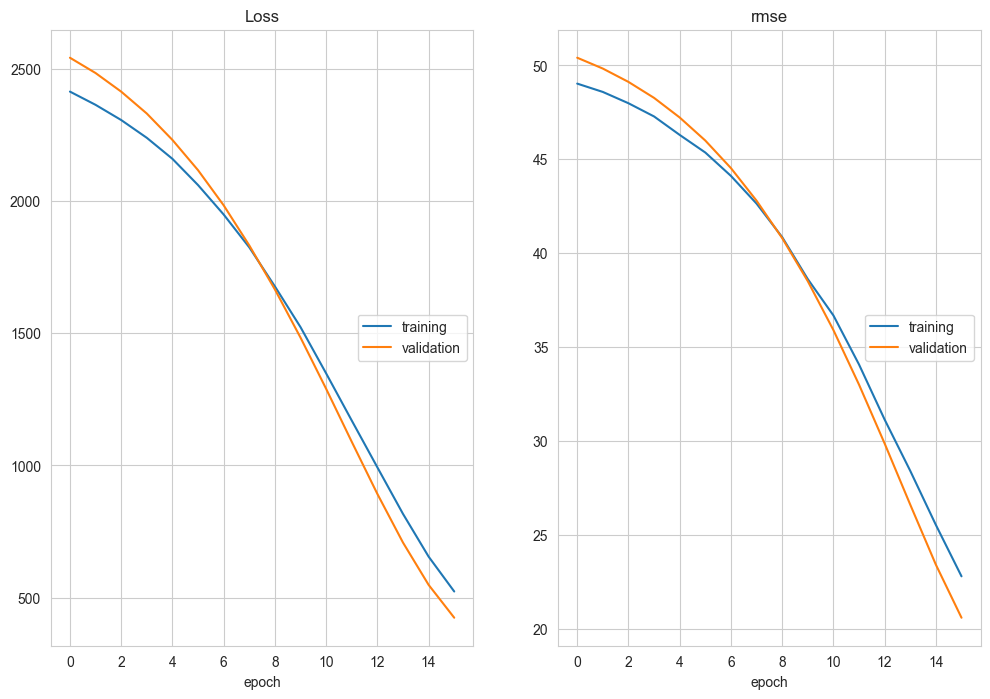

In [28]:
model = MLP(dim_num)
model.cuda()
device = torch.device("cuda")

criterion = nn.MSELoss()
# criterion = nn.L1Loss()
# optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

starttime = time.perf_counter()
liveloss = PlotLosses()
train_model(train_dl, val_dl, model, criterion, optimizer, EPOCHS, './models/MLP_Hugo.pth')
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### 3.2 - Treino com cross-validation

In [31]:
# Perform cross-validation
data = pd.read_csv(PATH_TRAIN, header=0)
kf = KFold(n_splits=K_FOLDS, shuffle=True)
timelist=[]

liveloss = PlotLosses()
for fold, (train_index, val_index) in enumerate(kf.split(data)):
    print(f"Fold {fold + 1}/{K_FOLDS}")
    
    # Split the data into training and validation sets for this fold
    train_data = CSVDataset(data.iloc[train_index])
    val_data = CSVDataset(data.iloc[val_index])
    
    # Create train and validation data loaders
    train_dl2 = DataLoader(train_data, batch_size=len(train_data), shuffle=True)
    val_dl2 = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

    # Load model
    try:
        model2= torch.load("./models/MLP_Hugo-cross.pth") ### modelo treinado anteriormente
    except:
        # model2= torch.load("./models/MLP_Hugo.pth") ### modelo treinado anteriormente
        model2 = MLP(dim_num)
        model2.cuda()
    model2.to(device)

    # Train the model
    criterion2 = nn.MSELoss()
    # criterion2 = nn.L1Loss()
    # optimizer2 = SGD(model2.parameters(), lr=LEARNING_RATE) 
    optimizer2 = Adam(model2.parameters(), lr=LEARNING_RATE)
    
    starttime = time.perf_counter()
    train_model(train_dl2, val_dl2, model2, criterion2, optimizer2, K_EPOCHS, './models/MLP_Hugo-cross.pth')
    endtime = time.perf_counter()
    timelist.append(endtime - starttime)

print(f"Tempo gasto: {sum(timelist)} segundos")

KeyboardInterrupt: 

# 4 Avaliar o Modelo

In [242]:
def evaluate_model(val_dl, model):
    predictions = list()
    actual_values = list()
    for i, (inputs, labels) in enumerate(val_dl):
        inputs=inputs.to(device)
        labels=labels.to(device)
        # avaliar o modelo com os casos de teste
        yprev = model(inputs)
        # retirar o array numpy
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        actual = actual.reshape((len(actual), 1))
        # guardar
        predictions.append(yprev)
        actual_values.append(actual)
        break

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

# avaliar o modelo
actual_values, predictions = evaluate_model(val_dl, model2)
#actuals, predictions = evaluate_model(train_dl, model)
for r,p in zip(actual_values, predictions):
    print(f'real:{r} previsão:{p}')
# calcular a accuracy
mse = mean_squared_error(actual_values, predictions)
print(f'MSE: {mse:0.3f}, RMSE: {np.sqrt(mse):0.3f}\n')

real:[46.] previsão:[37.940533]
real:[68.] previsão:[65.75878]
real:[57.] previsão:[59.41195]
real:[51.] previsão:[50.471542]
real:[56.] previsão:[54.873295]
real:[40.] previsão:[32.510273]
real:[59.] previsão:[63.595238]
real:[58.] previsão:[59.77352]
real:[62.] previsão:[61.053123]
real:[79.] previsão:[75.28246]
real:[65.] previsão:[61.342743]
real:[68.] previsão:[67.087006]
real:[18.] previsão:[17.960646]
real:[15.] previsão:[16.248194]
real:[65.] previsão:[65.921616]
real:[71.] previsão:[75.87057]
real:[16.] previsão:[16.818466]
real:[40.] previsão:[39.387985]
real:[18.] previsão:[20.17934]
real:[15.] previsão:[13.73149]
real:[19.] previsão:[21.395365]
real:[19.] previsão:[18.347795]
MSE: 10.288, RMSE: 3.207



# 5 Testar o Modelo

In [244]:
from collections import Counter


test_dl, test_dl_all = prepare_test_data_loaders(PATH_TEST)

model = torch.load('./Models/MLP_Hugo-cross.pth')
model.eval()

predictions_ = []

with torch.no_grad():
    for data in test_dl:
        data = data.to(device)
        output = model(data)
        predictions_.extend(output.tolist())

predictions = []
for prediction in predictions_:
    for p in prediction:
        predictions.append(int(p))

result = pd.read_csv('./data/example_submission.csv')
result['age']=predictions
result.to_csv('./results/res.csv', index=False)


res = pd.read_csv('./results/res.csv')
sub1 = pd.read_csv('./results/sub8.csv')
res['agesub1']=sub1['age']
res['dif']=sub1['age']-res['age']
print(res)
print(sum(res['dif']))
print(sum(abs(res['dif'])))

    id  age  agesub1  dif
0    1   22       22    0
1    2   21       21    0
2    3   16       16    0
3    4   21       21    0
4    5   19       19    0
5    6   23       23    0
6    7   54       54    0
7    8   38       38    0
8    9   60       60    0
9   10   67       67    0
10  11   66       66    0
11  12   71       71    0
12  13   71       71    0
13  14   71       71    0
14  15   17       17    0
15  16   18       18    0
16  17   19       19    0
17  18   27       27    0
18  19   18       18    0
19  20   27       27    0
20  21   47       47    0
21  22   57       57    0
22  23   56       56    0
23  24   78       78    0
24  25   57       57    0
25  26   66       66    0
26  27   60       60    0
27  28   68       68    0
0
0
